In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
#from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Zbiór danych

Pochodzi z platformy Kaggle: https://www.kaggle.com/datasets/datasnaek/mbti-type .

In [3]:
#każdy rząd składa się z typu osobowości i 50 ostatnich postów
df = pd.read_csv('mbti_1.csv', sep=',')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
#16 typów osobowości - nazwy klas
types = df.type.unique().tolist()
print(types)

#dodanie kolumny z klasami wyrażonymi liczbami (0 - 15)
df['class_no'] = df.apply(lambda x: types.index(x['type']), axis=1)

df

['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP', 'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']


,type,posts,class_no
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,2
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",3
4,ENTJ,'You're fired.|||That's another silly misconce...,4
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,8
8671,ENFP,'So...if this thread already exists someplace ...,7
8672,INTP,'So many questions when i do these things. I ...,2
8673,INFP,'I am very conflicted right now when it comes ...,6


In [5]:
#słownik odkodowujący
idx_to_type = {}
for i, t in enumerate(types): idx_to_type[i] = t

idx_to_type

{0: 'INFJ',
 1: 'ENTP',
 2: 'INTP',
 3: 'INTJ',
 4: 'ENTJ',
 5: 'ENFJ',
 6: 'INFP',
 7: 'ENFP',
 8: 'ISFP',
 9: 'ISTP',
 10: 'ISFJ',
 11: 'ISTJ',
 12: 'ESTP',
 13: 'ESFP',
 14: 'ESTJ',
 15: 'ESFJ'}

In [6]:
#zamiana separatora postów na zwykłą spację
df['posts_merged'] = df['posts'].str.replace(pat = '|||', repl = ' ')

In [7]:
df.head()

,type,posts,class_no,posts_merged
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...
1,ENTP,'I'm finding the lack of me in these posts ver...,1,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...,2,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",3,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...,4,'You're fired. That's another silly misconcept...


### Rozpakowanie postów

Każdy z wierszy zawiera wewnątrz 50 postów. Nie rozdzielamy ich, są już złączone w jeden długi tekst.

In [8]:
#usunięcie rozdzielonej kolumny
df = df.drop(columns = ['posts'])

In [9]:
#zmiana typów zmiennych
df = df.astype({'type':'string', 'posts_merged':'string'})

In [10]:
df.head()

,type,class_no,posts_merged
0,INFJ,0,'http://www.youtube.com/watch?v=qsXHcwe3krw ht...
1,ENTP,1,'I'm finding the lack of me in these posts ver...
2,INTP,2,'Good one _____ https://www.youtube.com/wat...
3,INTJ,3,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,4,'You're fired. That's another silly misconcept...


Rezygnujemy z dalszej obróbki tekstu.

### Podział danych

In [11]:
from sklearn.model_selection import train_test_split

# Split 80/20
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0, shuffle=True, stratify=df.type)

In [12]:
# X_train = df_train.posts_merged
# Y_train = df_train.class_no

# X_test = df_test.posts_merged
# Y_test = df_test.class_no

### Modelowanie - BERT

https://www.tensorflow.org/text/tutorials/classify_text_with_bert

In [13]:
# !pip install tf-models-official

In [14]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

c:\Users\marta\anaconda3\envs\mgr\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\marta\anaconda3\envs\mgr\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you wa

In [15]:
#@title Choose a BERT model to fine-tune

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

Pierwsza próba

In [28]:
# 1. wszystkie dokładności na zbiorze walidacyjnym wynoszą 16.95 - też musi mieć batch (aby otrzymać wymiary None, ...)?
# 2. Model się nie trenuje
# 3. Czy oczyszczenie tekstu z linków itp. nie byłoby jednak wskazane przed automatycznym preprocessingiem?
# 4. Czy trenować inny model BERT/preprocessingu?
# 5. Czy Softmax i 16 wyjść działa w tym wypadku? (!)
# 6. A może dołożyć jedną warstwę Dense?

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

In [16]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [17]:
text_test = [df_train.posts_merged[0]]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1005 8299 1024 1013 1013 7479 1012 7858 1012 4012 1013]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [19]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 6.5736336e-01  9.9745631e-01 -9.7849406e-05  2.9962434e-02
  3.7829421e-02  3.3249059e-01  9.9790323e-01 -9.8571795e-01
 -1.8011615e-01 -9.6215922e-01  1.3089763e-02 -7.6979309e-01]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.06830819  0.45557562  1.1621614  ...  0.41028792  0.0500593
  -0.39510858]
 [ 0.3731444   0.18699168  0.542082   ...  1.4074367  -0.26444644
  -0.0275875 ]
 [ 0.73036915  0.93654436  0.2551577  ... -1.1039606   0.23814142
   0.85410523]
 ...
 [ 0.6221207   1.5514325  -0.59081477 ... -1.8487356  -0.04348311
   0.1687791 ]
 [ 0.50480175  0.99654615  0.02790453 ... -0.57010263  0.11440703
  -0.16826288]
 [-0.17323332  1.0768743   1.1634693  ...  1.3083084   0.24158908
   0.60360456]]


In [20]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(16, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [21]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))
bert_raw_result

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[0.10370775, 0.12337923, 0.04419024, 0.02131447, 0.07705242,
        0.0234772 , 0.08212706, 0.21794407, 0.02045225, 0.03153383,
        0.0470459 , 0.05708288, 0.02338609, 0.01996765, 0.0312772 ,
        0.07606178]], dtype=float32)>

In [22]:
print(classifier_model.summary())  # 4 warstwy

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [23]:
classifier_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [378]:
df_train = df_train.rename(columns={'class_no': 'label', 'posts_merged': 'text'})
df_test = df_test.rename(columns={'class_no': 'label', 'posts_merged': 'text'})

In [379]:
# ds = tf.data.Dataset.from_tensor_slices(dict(df_train.loc[:, 'label':]))
# ds_test = tf.data.Dataset.from_tensor_slices(dict(df_test.loc[:, 'label':]))

In [380]:
# import tensorflow.keras.utils as ku
# df_train['label_16'] = df_train.apply(lambda x: ku.to_categorical(x['label'], 16), axis=1)
# df_test['label_16'] = df_test.apply(lambda x: ku.to_categorical(x['label'], 16), axis=1)

# df_test.label_16

In [381]:
# tf.one_hot(tf.convert_to_tensor(df_train.loc[:, 'label'], dtype=tf.int16), 16)
tf.one_hot(df_train.loc[:, 'label'], 16)

<tf.Tensor: shape=(6940, 16), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [382]:
ds = tf.data.Dataset.from_tensor_slices((df_train.loc[:, 'text'], tf.one_hot(df_train.loc[:, 'label'], 16)))
ds_test = tf.data.Dataset.from_tensor_slices((df_test.loc[:, 'text'], tf.one_hot(df_test.loc[:, 'label'], 16)))

In [383]:
ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(16,), dtype=tf.float32, name=None))>

In [384]:
ds.take(0)

<TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(16,), dtype=tf.float32, name=None))>

In [385]:
ds.take(0).element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(16,), dtype=tf.float32, name=None))

In [386]:
ds = ds.batch(8)
# ds_test = ds_test.batch(8)

In [387]:
ds.take(0).element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))

In [388]:
AUTOTUNE = tf.data.AUTOTUNE
ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

Trening

In [349]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=ds, validation_data=ds_test, epochs=20)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/20


868/868 [==============================] - 81s 93ms/step - loss: 2.4743 - categorical_accuracy: 0.1722 - val_loss: 2.4775 - val_categorical_accuracy: 0.1695
Epoch 2/20
868/868 [==============================] - 82s 94ms/step - loss: 2.4704 - categorical_accuracy: 0.1684 - val_loss: 2.4499 - val_categorical_accuracy: 0.1695
Epoch 3/20
868/868 [==============================] - 82s 94ms/step - loss: 2.4669 - categorical_accuracy: 0.1726 - val_loss: 2.4598 - val_categorical_accuracy: 0.1695
Epoch 4/20
868/868 [==============================] - 81s 93ms/step - loss: 2.4489 - categorical_accuracy: 0.1756 - val_loss: 2.4664 - val_categorical_accuracy: 0.1695
Epoch 5/20
868/868 [==============================] - 81s 94ms/step - loss: 2.4578 - categorical_accuracy: 0.1725 - val_loss: 2.4454 - val_categorical_accuracy: 0.1695
Epoch 6/20
868/868 [==============================] - 82s 95ms/step - loss: 2.4563 - categorical_accuracy: 0.1761 - val_loss: 2.4653 - val_categorical_accuracy: 0.1695
Epo

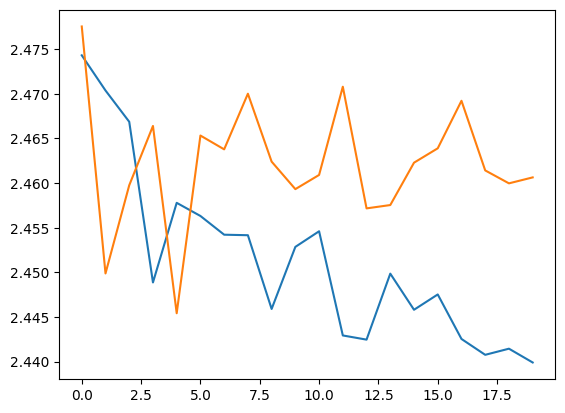

In [350]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

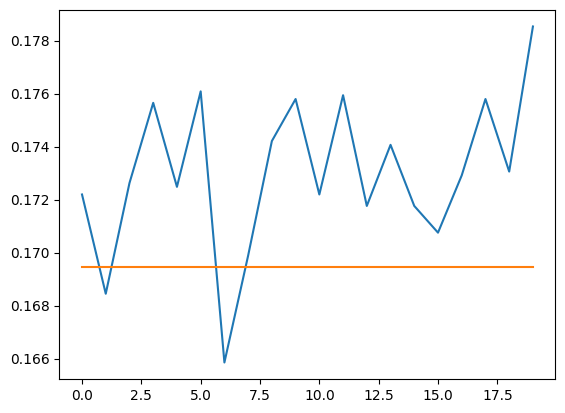

In [351]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

Druga próba

In [ ]:
# 1. wszystkie dokładności na zbiorze walidacyjnym wynoszą 16.95 - mimo że dołożono batch na zbiorze testowym
# 2. Model się nie trenuje
# 3. Czy oczyszczenie tekstu z linków itp. nie byłoby jednak wskazane przed automatycznym preprocessingiem?
# 4. Czy trenować inny model BERT/preprocessingu? - wybrano model o 2x liczbie warstw
# 5. Czy Softmax i 16 wyjść działa w tym wypadku? (!)
# 6. A może dołożyć jedną warstwę Dense?

In [16]:
#bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  ResourceExhaustedError
#bert_model_name = 'small_bert/bert_en_uncased_L-12_H-768_A-12' ResourceExhaustedError
bert_model_name = 'small_bert/bert_en_uncased_L-8_H-512_A-8'

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [17]:
# bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
# bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [18]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(16, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [19]:
classifier_model2 = build_classifier_model()
print(classifier_model2.summary())   #8 warstw

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [20]:
classifier_model2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [33]:
#Datasety
df_train = df_train.rename(columns={'class_no': 'label', 'posts_merged': 'text'})
df_test = df_test.rename(columns={'class_no': 'label', 'posts_merged': 'text'})

ds = tf.data.Dataset.from_tensor_slices((df_train.loc[:, 'text'], tf.one_hot(df_train.loc[:, 'label'], 16)))
ds_test = tf.data.Dataset.from_tensor_slices((df_test.loc[:, 'text'], tf.one_hot(df_test.loc[:, 'label'], 16)))

In [34]:
ds.take(0).element_spec, ds_test.take(0).element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(16,), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(16,), dtype=tf.float32, name=None)))

In [35]:
ds = ds.batch(8)
ds_test = ds_test.batch(8)

In [36]:
ds.take(0).element_spec, ds_test.take(0).element_spec

((TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)))

In [37]:
AUTOTUNE = tf.data.AUTOTUNE
ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
ds_test = ds_test.cache().prefetch(buffer_size=AUTOTUNE)

In [38]:
ds.take(0).element_spec, ds_test.take(0).element_spec

((TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)),
 (TensorSpec(shape=(None,), dtype=tf.string, name=None),
  TensorSpec(shape=(None, 16), dtype=tf.float32, name=None)))

Trening

In [39]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model2.fit(x=ds, validation_data=ds_test, epochs=20)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1
Epoch 1/20


868/868 [==============================] - 133s 145ms/step - loss: 2.5183 - categorical_accuracy: 0.1729 - val_loss: 2.4637 - val_categorical_accuracy: 0.1695
Epoch 2/20
868/868 [==============================] - 125s 145ms/step - loss: 2.5069 - categorical_accuracy: 0.1671 - val_loss: 2.4526 - val_categorical_accuracy: 0.1695
Epoch 3/20
868/868 [==============================] - 127s 146ms/step - loss: 2.4886 - categorical_accuracy: 0.1725 - val_loss: 2.4656 - val_categorical_accuracy: 0.1695
Epoch 4/20
868/868 [==============================] - 126s 145ms/step - loss: 2.4871 - categorical_accuracy: 0.1661 - val_loss: 2.4879 - val_categorical_accuracy: 0.1695
Epoch 5/20
868/868 [==============================] - 125s 144ms/step - loss: 2.4738 - categorical_accuracy: 0.1651 - val_loss: 2.4514 - val_categorical_accuracy: 0.1695
Epoch 6/20
868/868 [==============================] - 125s 145ms/step - loss: 2.4740 - categorical_accuracy: 0.1695 - val_loss: 2.4710 - val_categorical_accuracy

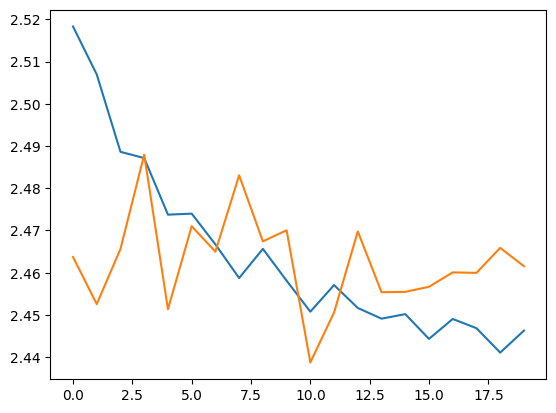

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

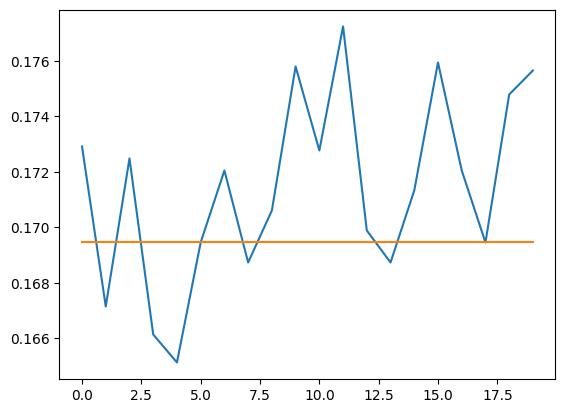

In [41]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])